## Wind Geometries

Code for calculating velocity as a function of viewing angle for a simple toy model.

Import some basic stuff.

In [74]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as pl
from scipy.interpolate import UnivariateSpline as spline # Splines are good.
from ufo_reflection import * # Functions for loading the data are here
from disk_blueshift import * # Calculates blueshifts on the disk as a function of inclination (written by D. Buisson)

### Define functions for some simple geometries. 
All return $h$, the height of the wind as a function of radius $r$.

In [75]:

# Simple conical geometry with launch radius and inclination
def cone(r,launch_r=20.,iw=30.):
    h=np.zeros(r.shape)
    h[r>launch_r]=(r[r>launch_r]-launch_r)/np.tan(np.pi*iw/180.)
    return h

# Line of sight to origin. Same as cone with launch_r=0
def los(r,i_view=45):
    return r*np.tan(np.pi*(90.-i_view)/180.)

# Smoothly curving wind, with launch radius, curvature radius, and final inclination
def streamline(r,launch_r=20.,r_curv=100.,i_final=30.):
    rf=r_curv*(1.-np.cos(np.pi*i_final/180.))+launch_r
    hf=( r_curv**2-(r_curv+launch_r-rf)**2 )**0.5

    h=np.zeros(r.shape)
    
    # This throws up a warning but should be fine, the Nans get replaced in the next step
    h[r>launch_r]=( r_curv**2-(r_curv+launch_r-r[r>launch_r])**2 )**0.5

    h[r>rf]=hf+cone(r[r>rf],launch_r=rf,iw=i_final)

    return h

### Function to find the velocity of a wind following the streamline velocity. 
Has the same parameters as the streamline geometry above, and also a characteristic velocity and radial exponent for the velocity, following: $v_{wind}=v_\mathrm{inf}\times(r_v/(r_v+r))^\beta$

In [76]:
def find_velocities(v0=0.,v_inf=0.4,i_view=45.,launch_r=20.,r_curv=100.,i_final=30.,beta=1,r_v=1000.):
    rs=np.logspace(0,5,1000)
    wind_hs=streamline(rs,launch_r,r_curv,i_final)
    los_hs=los(rs,i_view)
    los_gradient=los(1.,i_view)

    # Splines! Splines everywhere.
    splinefit_wind=spline(rs,wind_hs,s=0)
    gradient_wind=splinefit_wind.derivative()
    splinefit_diff=spline(rs,wind_hs-los_hs,s=0)

    # Find roots of the difference between LOS and wind
    # i.e. points where wind and LOS intercept
    roots=splinefit_diff.roots()

    # Gradient of wind at intercepts gives angles between LOS and wind
    wind_gradients=gradient_wind(roots)
    angles=abs(np.arctan(wind_gradients)-np.arctan(los_gradient))

    # Velocities are just v*cosine of the angle between wind and LOS
    
    velocities=v0+v_inf*np.cos(angles)*(1.-r_v/(r_v+roots))**beta

    return velocities

### Plot streamlines geometry, for illustration. 
(Warning should be safe to ignore)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


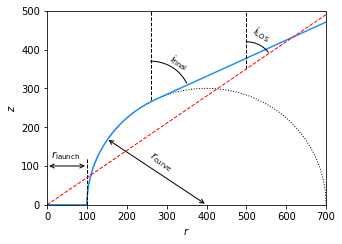

In [77]:
fig1=pl.figure(figsize=(5,3.57))

ax=pl.subplot(111)
ax.set_xlim(0,700)
ax.set_ylim(0,500)
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$z$')


radii=np.linspace(0,1000,1000)
stream_hs=streamline(radii,launch_r=100.,r_curv=300.,i_final=65.)
stream_hs_2=streamline(radii,launch_r=100.,r_curv=300.,i_final=180.)

ax.plot(radii,stream_hs_2,color='k',ls=':',lw=1)
ax.plot(radii,stream_hs,color='dodgerblue')

pl.annotate(s='', xy=(0,100), xytext=(100,100), arrowprops=dict(arrowstyle='<->'))
pl.text(10,120,r'$r_\mathrm{launch}$')

pl.annotate(s='', xy=(400,0), xytext=(150,170), arrowprops=dict(arrowstyle='<->'))
pl.text(250,120,r'$r_\mathrm{curve}$',rotation=325)

# Vertical line for i_final angle
pl.plot([260,260],[270,500],c='k',ls='--',lw=1)

# Vertical line for r_launch
pl.plot([100,100],[0,120],c='k',ls='--',lw=1)

# Vertical line for i
pl.plot([500,500],[350,500],c='k',ls='--',lw=1)

# Arc for i_final
xs_temp=np.linspace(260,350,100)
ys_temp=[270.+(100.**2-(x-260)**2)**0.5 for x in xs_temp]
pl.plot(xs_temp,ys_temp,ls='-',c='k',lw=1)

# Arc for i
xs_temp=np.linspace(500,555,100)
ys_temp=[350.+(70.**2-(x-500)**2)**0.5 for x in xs_temp]
pl.plot(xs_temp,ys_temp,ls='-',c='k',lw=1)

pl.text(300,370,r'$i_\mathrm{final}$',rotation=330)
pl.text(510,440,r'$i_\mathrm{LOS}$',rotation=330)

xs_temp=np.linspace(0,700,2)
pl.plot(xs_temp,los(xs_temp,i_view=55),color='r',ls='--',lw=1)

# pl.text()
pl.savefig('geometry_fig.pdf',bbox_inches='tight')
pl.show()



### Load inclination/velocity data for AGN sample:

In [78]:
sources=load_sources('data.tsv')


Analysing 1H 0707+495
Reflection loaded
43.0+/-2.0 Kara+15
3 UFOs loaded
Merging UFOs...
Consolodated to 2 UFOs
0.11+0.01-0.02 Dauser+12
0.18+/-0.009 Hagino+16; Dauser+12

Analysing IRAS 13349+2438
Reflection loaded
48.0+2.0-1.0 Parker+18
1 UFOs loaded
0.13+/-0.01 Parker+18

Analysing Ark 120
Reflection loaded
45.0+5.0-2.0 Garcia+14
1 UFOs loaded
0.29+/-0.02 Tombesi+11a

Analysing PDS 456
Reflection loaded
65.0+/-2.0 Chiang+17
14 UFOs loaded
Merging UFOs...
Consolodated to 2 UFOs
0.278+/-0.003 Reeves+18; Matzeu+17
0.46+/-0.02 Reeves+18

Analysing Mrk 79
Reflection loaded
24.0+/-1.0 Gallo+11
1 UFOs loaded
0.092+/-0.004 Tombesi+11a

Analysing IC 4329A
Reflection loaded
35.0+/-5.0 Mantovani+14
1 UFOs loaded
0.098+/-0.004 Tombesi+11a

Analysing Swift J2127
Reflection loaded
49.0+/-2.0 Marinucci+14b
1 UFOs loaded
0.231+/-0.006 Gofford+13

Analysing NGC 4051
Reflection loaded
37.0+/-5.0 Patrick+12/Risaliti+?
3 UFOs loaded
Merging UFOs...
Consolodated to 2 UFOs
0.0185+/-0.004 Gofford+13; Tom

### Get inclination/velocity points for the sample:

In [79]:
vs, v_errs, points, errs, llim_vs, llim_v_errs, llims, ulim_vs, ulim_v_errs, ulims = get_points(sources)


Getting points and limits
1H 0707+495 2 UFOs
IRAS 13349+2438 1 UFOs
Ark 120 1 UFOs
PDS 456 2 UFOs
Mrk 79 1 UFOs
IC 4329A 1 UFOs
Swift J2127 1 UFOs
NGC 4051 2 UFOs
Mrk 841 1 UFOs
Mrk 766 2 UFOs
1H 0419-577 1 UFOs
3C 111 1 UFOs
NGC 5506 1 UFOs
PG 1211+143 3 UFOs
Mrk 509 3 UFOs
IRAS 13224-3809 1 UFOs
MR 2251-178 1 UFOs
MCG-5-23-16 1 UFOs
NGC 4151 2 UFOs


### Plot points and wind model
Plotting several lines for each playing with some of the parameters

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


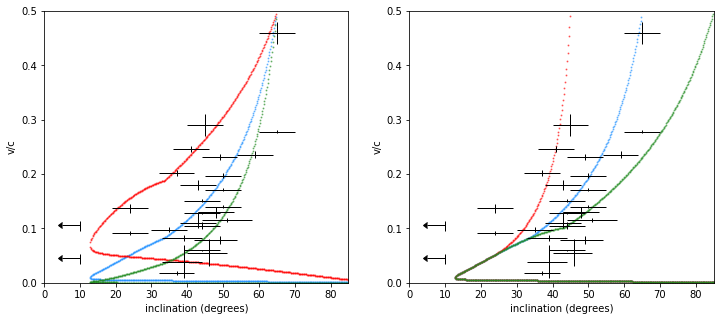

In [92]:

##############################################
#### Settings for the model to be overplotted:
v_inf    = 0.5
i_wind   = 65.
launch_r = 10.
r_curve  = 400.
r_exp    = 1
r_v      = 1000
##############################################

fig2=pl.figure(figsize=(12,5))

ax1=pl.subplot(121)
ax1.set_xlim(0,85)
ax1.set_ylim(0,0.5)
ax1.set_ylabel('v/c')
ax1.set_xlabel('inclination (degrees)')


#  Plot the points
pl.errorbar(points,vs,v_errs.T,errs.T,ls='none',lw=1,color='k')

# Plot upper limits:
if len(ulims)>0:
    pl.errorbar(ulims,ulim_vs,ulim_v_errs,0,ls='none',lw=1,color='k')
    pl.errorbar(ulims, ulim_vs,0, 5, xuplims=True,ls='none',lw=1,color='k')
    

for i in np.linspace(0,90,500):
    wind_vs=find_velocities(v_inf=v_inf,i_view=i,i_final=i_wind,launch_r=launch_r,r_curv=r_curve,beta=r_exp,r_v=r_v)
    if len(vs)>0:
        ax1.scatter([i]*len(wind_vs),wind_vs,color='dodgerblue',s=1,alpha=0.5)
        

for i in np.linspace(0,90,500):
    wind_vs=find_velocities(v_inf=v_inf,i_view=i,i_final=i_wind,launch_r=launch_r,r_curv=r_curve,beta=r_exp-0.5,r_v=r_v)
    if len(vs)>0:
        ax1.scatter([i]*len(wind_vs),wind_vs,color='r',s=1,alpha=0.5)
        

for i in np.linspace(0,90,500):
    wind_vs=find_velocities(v_inf=v_inf,i_view=i,i_final=i_wind,launch_r=launch_r,r_curv=r_curve,beta=r_exp+0.5,r_v=r_v)
    if len(vs)>0:
        ax1.scatter([i]*len(wind_vs),wind_vs,color='forestgreen',s=1,alpha=0.5)
# pl.legend()
        
ax2=pl.subplot(122)
ax2.set_xlim(0,85)
ax2.set_ylim(0,0.5)
ax2.set_ylabel('v/c')
ax2.set_xlabel('inclination (degrees)')



#  Plot the points
pl.errorbar(points,vs,v_errs.T,errs.T,ls='none',lw=1,color='k')

# Plot upper limits:
if len(ulims)>0:
    pl.errorbar(ulims,ulim_vs,ulim_v_errs,0,ls='none',lw=1,color='k')
    pl.errorbar(ulims, ulim_vs,0, 5, xuplims=True,ls='none',lw=1,color='k')
    
for i in np.linspace(0,90,500):
    wind_vs=find_velocities(v_inf=v_inf,i_view=i,i_final=i_wind,launch_r=launch_r,r_curv=r_curve,beta=r_exp,r_v=r_v)
    if len(vs)>0:
        ax2.scatter([i]*len(wind_vs),wind_vs,color='dodgerblue',s=1,alpha=0.5)

    
for i in np.linspace(0,90,500):
    wind_vs=find_velocities(v_inf=v_inf,i_view=i,i_final=i_wind-20,launch_r=launch_r,r_curv=r_curve,beta=r_exp,r_v=r_v)
    if len(vs)>0:
        ax2.scatter([i]*len(wind_vs),wind_vs,color='r',s=1,alpha=0.5)
    
for i in np.linspace(0,90,500):
    wind_vs=find_velocities(v_inf=v_inf,i_view=i,i_final=i_wind+20,launch_r=launch_r,r_curv=r_curve,beta=r_exp,r_v=r_v)
    if len(vs)>0:
        ax2.scatter([i]*len(wind_vs),wind_vs,color='forestgreen',s=1,alpha=0.5)        
        
pl.savefig('wind_velocity.pdf',bbox_inches='tight')



### Plot points and line for disk absorption model.

In [ ]:
##############################################
#### Settings for the model to be overplotted:
a=0.9 #spin. Actually not a strong dependence, because g_max is not at the ISCO
##############################################

fig3=pl.figure(figsize=(6,5))

ax=pl.subplot(111)
ax.set_xlim(0,85)
ax.set_ylim(0.,0.5)
ax.set_ylabel('v/c')
ax.set_xlabel('inclination (degrees)')


#  Plot the points
pl.errorbar(points,vs,v_errs.T,errs.T,ls='none',lw=1,color='k')

# Plot upper limits:
if len(ulims)>0:
    pl.errorbar(ulims,ulim_vs,ulim_v_errs,0,ls='none',lw=1,color='k')
    pl.errorbar(ulims, ulim_vs,0, 5, xuplims=True,ls='none',lw=1,color='k')
    

incls = np.arange(100)*.9

# blueshifts:
gs = np.empty(100)

i=-1
for incl in incls:
    i+=1
    gs[i] = gs[i] = g_max(a,incl)

# convert shifts to velocities:
disk_vs=[(g**2-1.)/(g**2+1.) for g in gs]
    
pl.plot(incls,disk_vs,color='r')

pl.savefig('disk_velocities.pdf',bbox_inches='tight')